1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- https://archive.ics.uci.edu/ml/machine-learning-databases/00222/

In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [113]:
file = 'bank-marketing/bank.csv'
df = pd.read_csv(file, delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


## Dataset Description
### Input variables:
   #### bank client data:
   1 - age (numeric)
   <br>2 - job : type of job _(categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")_ 
   <br>3 - marital : marital status _(categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)_
   <br>4 - education _(categorical: "unknown","secondary","primary","tertiary")_
   <br>5 - default: has credit in default? _(binary: "yes","no")_
   <br>6 - balance: average yearly balance, in euros _(numeric)_ 
   <br>7 - housing: has housing loan? _(binary: "yes","no")_
   <br>8 - loan: has personal loan? _(binary: "yes","no")_
   #### related with the last contact of the current campaign:
   9 - contact: contact communication type _(categorical: "unknown","telephone","cellular")_
  <br>10 - day: last contact day of the month _(numeric)_
  <br>11 - month: last contact month of year _(categorical: "jan", "feb", "mar", ..., "nov", "dec")_
  <br>12 - duration: last contact duration, in seconds _(numeric)_
   #### other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client _(numeric, includes last contact)_
  <br>14 - pdays: number of days that passed by after the client was last contacted from a previous campaign _(numeric, -1 means client was not previously contacted)_
  <br>15 - previous: number of contacts performed before this campaign and for this client _(numeric)_
  <br>16 - poutcome: outcome of the previous marketing campaign _(categorical: "unknown","other","failure","success")_

  #### Output variable (desired target):
  17 - y - has the client subscribed a term deposit? _(binary: "yes","no")_

In [114]:
df.y.replace({'yes': 1, 'no': 0}, inplace=True)

In [115]:
binary_columns = ['default', 'housing', 'loan']
categorical_columns = ['job', 'marital', 'education', 'month', 'poutcome', 'contact']
real_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

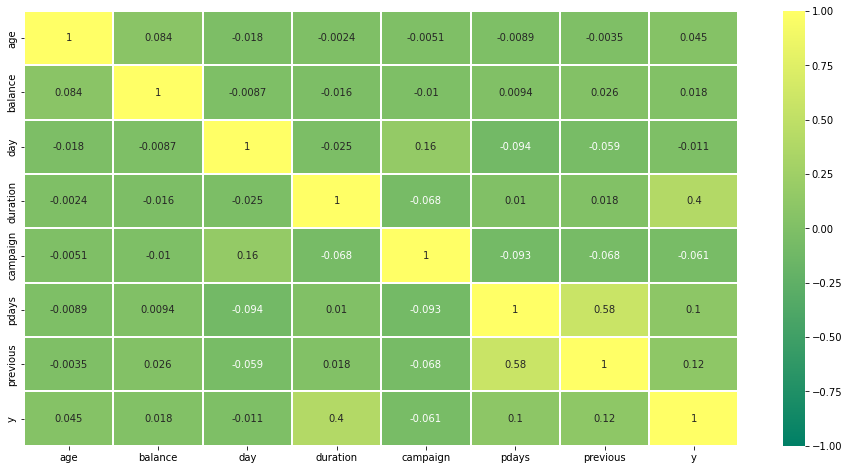

In [69]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot = True, cmap ="summer", linewidths=.2);

In [70]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579,0.115240
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562,0.319347
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000,1.000000


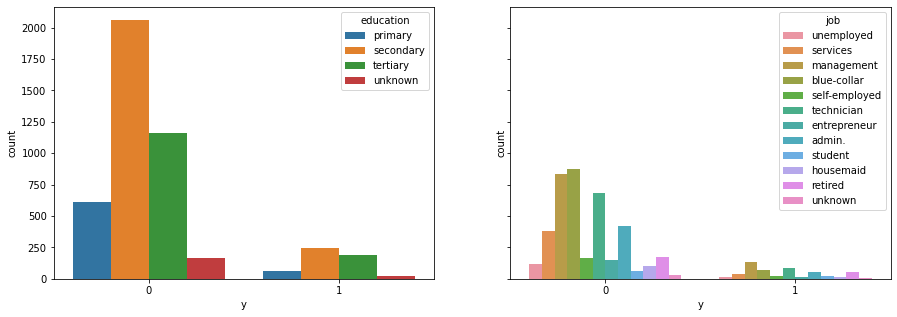

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.countplot(ax=axes[0], x=df.y, hue=df['education']);

sns.countplot(ax=axes[1], x=df.y, hue=df['job']);

2. сделать feature engineering

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
                
        return X[self.columns]

      
class Binarizer(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X[self.key].replace({'yes': 1, 'no': 0}, inplace=True)
        return X[self.key]

In [142]:
final_transformers = list()

for bin_col in binary_columns:
    bin_transformer = Pipeline([
        ('selector', FeatureSelector(column=bin_col)),
        ('binarizer', Binarizer(key=bin_col))
    ])
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in real_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    final_transformers.append((cont_col, cont_transformer))

    
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

3. обучить любой классификатор (какой вам нравится)

In [143]:
def evaluate_results(y_test, y_predict):
    
    print('=== Classification results ===')
    
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    
    acc = accuracy_score(y_test, y_predict)
    print('accuracy: %.2f%%' % (acc * 100.0))
    
    conf_matrix = confusion_matrix(y_test, y_predict)
    print('confusion matrix:\n', conf_matrix)
    
    return f1, roc, rec, prc, acc, conf_matrix

In [144]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

x_data = df.iloc[:,:-1]
y_data = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

model = xgb.XGBClassifier(eval_metric='logloss',
                          booster='dart',
                          gamma=0.05,
                          learning_rate=0.1,
                          max_depth=4,
                          n_estimators=4,
                          subsample=0.5,
                          use_label_encoder=False,
                          random_state=42)


pipe = Pipeline([
    ('features', feats),
    ('classifier', model)
])

pipe.fit(x_train, y_train)

y_predict = pipe.predict(x_test)

In [145]:
f1, roc, rec, prc, acc, conf_matrix = evaluate_results(y_test, y_predict)

=== Classification results ===
f1: 38.36%
roc: 62.59%
recall: 26.92%
precision: 66.67%
accuracy: 90.06%
confusion matrix:
 [[787  14]
 [ 76  28]]


In [146]:
models_results = {} 
models_results['XGBClassifier'] = {
                        'f_score': f1, 
                        'precision': prc,
                        'recall': rec,
                        'accuracy': acc,
                        'roc_auc': roc,
                        'conf_matrix': conf_matrix
                        }

4. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть

In [147]:
def splitPU(df, sample_size=0.25):
    mod_data = df.copy()

    # get the indices of the positives samples
    pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]

    # shuffle them
    np.random.shuffle(pos_ind)

    # leave just 25% of the positives marked
    pos_sample_len = int(np.ceil(sample_size * len(pos_ind)))
    
    print('=== Sampling data ===')
    print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
    pos_sample = pos_ind[:pos_sample_len]
    
    mod_data['y'] = 0
    mod_data.loc[pos_sample,'y'] = 1
    
    print()
    print('=== Target distribution ===')
    print('target variable:\n', mod_data.iloc[:,-1].value_counts())
    return mod_data

In [148]:
x_data = mod_data.iloc[:, :-1].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = df.iloc[:, -1].values # original class

5. применить random negative sampling для построения классификатора в новых условиях

In [149]:
def random_negative_sample(*args, **kwargs):  
    
    # shuffle data
    mod_data = splitPU(*args, **kwargs).sample(frac=1)

    # create negative sample
    neg_sample = mod_data[mod_data['y']==0][:len(mod_data[mod_data['y']==1])]

    # create test sample 
    sample_test = mod_data[mod_data['y']==0][len(mod_data[mod_data['y']==1]):]

    # create positive sample
    pos_sample = mod_data[mod_data['y']==1]
    print()
    print('(Negative sample shape) (Positive sample shape)')
    print(neg_sample.shape, pos_sample.shape)

    # create train sample
    sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)
    
    return sample_train, sample_test

In [150]:
# build classificator
model = xgb.XGBClassifier(eval_metric='logloss',
                          booster='dart',
                          gamma=0.05,
                          learning_rate=0.1,
                          max_depth=4,
                          n_estimators=4,
                          subsample=0.5,
                          use_label_encoder=False,
                          random_state=42)
pipe = Pipeline([
    ('features', feats),
    ('classifier', model)
])

data_train, data_test = random_negative_sample(df)

x = data_train.drop('y', axis=1)
y = data_train.y
pipe.fit(x, y)

# predicting on test data
y_predict = pipe.predict(x_test)

print()
f1, roc, rec, prc, acc, conf_matrix = evaluate_results(y_test, y_predict)

models_results['PU@25%+XGBClassifier'] = {
                        'f_score': f1, 
                        'precision': prc,
                        'recall': rec,
                        'accuracy': acc,
                        'roc_auc': roc,
                        'conf_matrix': conf_matrix
                        }


=== Sampling data ===
Using 131/521 as positives and unlabeling the rest

=== Target distribution ===
target variable:
 0    4390
1     131
Name: y, dtype: int64

(Negative sample shape) (Positive sample shape)
(131, 17) (131, 17)

=== Classification results ===
f1: 41.56%
roc: 75.91%
recall: 76.92%
precision: 28.47%
accuracy: 75.14%
confusion matrix:
 [[600 201]
 [ 24  80]]


6. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)

In [151]:
pd.DataFrame(models_results)

,XGBClassifier,PU@25%+XGBClassifier
f_score,0.383562,0.415584
precision,0.666667,0.284698
recall,0.269231,0.769231
accuracy,0.900552,0.751381
roc_auc,0.625876,0.759147
conf_matrix,"[[787, 14], [76, 28]]","[[600, 201], [24, 80]]"


7. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

In [152]:
pipe = Pipeline([
    ('features', feats),
    ('classifier', model)
])

sample_sizes_list = np.arange(0.10, 1.1, 0.1)

for sample_size in sample_sizes_list:
    data_train, data_test = random_negative_sample(df, sample_size=sample_size)

    x = data_train.drop('y', axis=1)
    y = data_train.y
    pipe.fit(x, y)

    # predicting on test data
    y_predict = pipe.predict(x_test)

    print()
    f1, roc, rec, prc, acc, conf_matrix = evaluate_results(y_test, y_predict)

    models_results[f'PU@{round(sample_size*100.0, 2)}%+XGBClassifier'] = {
                            'f_score': f1, 
                            'precision': prc,
                            'recall': rec,
                            'accuracy': acc,
                            'roc_auc': roc,
                            'conf_matrix': conf_matrix
                            }

=== Sampling data ===
Using 53/521 as positives and unlabeling the rest

=== Target distribution ===
target variable:
 0    4468
1      53
Name: y, dtype: int64

(Negative sample shape) (Positive sample shape)
(53, 17) (53, 17)

=== Classification results ===
f1: 40.35%
roc: 72.85%
recall: 67.31%
precision: 28.81%
accuracy: 77.13%
confusion matrix:
 [[628 173]
 [ 34  70]]
=== Sampling data ===
Using 105/521 as positives and unlabeling the rest

=== Target distribution ===
target variable:
 0    4416
1     105
Name: y, dtype: int64

(Negative sample shape) (Positive sample shape)
(105, 17) (105, 17)

=== Classification results ===
f1: 39.48%
roc: 73.74%
recall: 73.08%
precision: 27.05%
accuracy: 74.25%
confusion matrix:
 [[596 205]
 [ 28  76]]
=== Sampling data ===
Using 157/521 as positives and unlabeling the rest

=== Target distribution ===
target variable:
 0    4364
1     157
Name: y, dtype: int64

(Negative sample shape) (Positive sample shape)
(157, 17) (157, 17)

=== Classificat

In [244]:
results

,XGBClassifier,PU@25%+XGBClassifier,PU@10.0%+XGBClassifier,PU@20.0%+XGBClassifier,PU@30.0%+XGBClassifier,PU@40.0%+XGBClassifier,PU@50.0%+XGBClassifier,PU@60.0%+XGBClassifier,PU@70.0%+XGBClassifier,PU@80.0%+XGBClassifier,PU@90.0%+XGBClassifier,PU@100.0%+XGBClassifier
f_score,0.383562,0.415584,0.394805,0.4,0.403458,0.407767,0.416244,0.418605,0.436658,0.445087,0.468468,0.479339
precision,0.666667,0.284698,0.288066,0.270463,0.3,0.271478,0.303371,0.318182,0.340611,0.272727,0.335907,0.282759
recall,0.269231,0.769231,0.673077,0.730769,0.692308,0.759615,0.778846,0.740385,0.75,0.807692,0.836538,0.788462
accuracy,0.900552,0.751381,0.771271,0.742541,0.779006,0.738122,0.769061,0.787845,0.80442,0.730387,0.79116,0.745856
roc_auc,0.625876,0.759147,0.728548,0.73742,0.741285,0.747473,0.773318,0.767196,0.780743,0.764021,0.810903,0.764393
conf_matrix,"[[787, 14], [76, 28]]","[[600, 201], [24, 80]]","[[628, 173], [34, 70]]","[[596, 205], [28, 76]]","[[633, 168], [32, 72]]","[[589, 212], [25, 79]]","[[615, 186], [23, 81]]","[[636, 165], [27, 77]]","[[650, 151], [26, 78]]","[[577, 224], [20, 84]]","[[629, 172], [17, 87]]","[[593, 208], [22, 82]]"


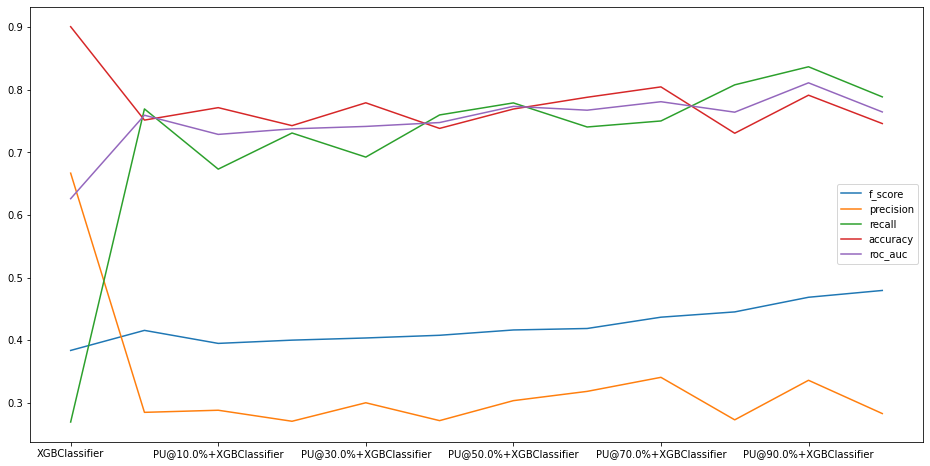

In [243]:
plt.figure(figsize=(16, 8))

for idx in results.index[:-1]:
    results.loc[idx, :].plot(legend=True)

Данные изначально были сильно разбалансированны. Когда модели, обученные с помощью PU-learning, предсказывают, что клиент оформит срочный депозит, они верны в среднем в 30% случаев, при этом правильно определяют 70-80% из всех таргетных значений. 